<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/ABOD_PyOd%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ABOD (PyOD) 異常検知（初心者向け・安定版）
# 手順:
# 1) 2次元の正規分布（相関あり）から学習用「正常」& テスト（正常+異常）を作成
# 2) 学習統計量でZ標準化
# 3) ABOD を学習（method='fast'）
# 4) 学習スコアの上位 α 分位点をしきい値に → テストを判定
# 5) 可視化：散布図＋等高線、スコアのヒスト（NaN/Inf除去 & クリップ）

!pip -q install -U pyod

import numpy as np
import matplotlib.pyplot as plt
from pyod.models.abod import ABOD

np.random.seed(0)

In [8]:
# ===== パラメータ =====
k = 20            # 近傍数（10〜30で調整）
alpha = 0.99      # 学習スコアの上位 α 分位点をしきい値に
n_train = 400
n_test_norm = 200
n_test_out = 20

In [9]:
# ===== データ作成（相関ありガウス＋異常）=====
mu = np.array([0.0, 0.0])
Sigma = np.array([[3.0, 2.0], [2.0, 5.0]])
train = np.random.multivariate_normal(mu, Sigma, size=n_train)
test_norm = np.random.multivariate_normal(mu, Sigma, size=n_test_norm)

mu_out = np.array([6.0, -6.0])
Sigma_out = np.array([[1.0, 0.2], [0.2, 1.0]])
test_out = np.random.multivariate_normal(mu_out, Sigma_out, size=n_test_out)

test = np.vstack([test_norm, test_out])
labels = np.hstack([np.zeros(len(test_norm), dtype=int), np.ones(len(test_out), dtype=int)])  # 0=正常,1=異常

In [10]:
# ===== 標準化（学習統計量のみで）=====
mu_hat = train.mean(axis=0)
std_hat = train.std(axis=0, ddof=1)
std_hat = np.where(std_hat == 0, 1.0, std_hat)
train_z = (train - mu_hat) / std_hat
test_z  = (test  - mu_hat) / std_hat

In [11]:
# ===== ABOD 学習 =====
abod = ABOD(method='fast', n_neighbors=k)
abod.fit(train_z)
print("[INFO] ABOD fitted.")


[INFO] ABOD fitted.


In [12]:
# ===== スコア（大きいほど異常）=====
score_train = abod.decision_function(train_z)
score_test  = abod.decision_function(test_z)

# 非有限値を除去してしきい値を計算
finite_train = np.isfinite(score_train)
if not np.any(finite_train):
    raise RuntimeError("学習スコアに有効値がありません（NaN/Inf）。標準化や k を見直してください。")
thr = np.quantile(score_train[finite_train], alpha)

pred = (score_test > thr).astype(int)

# ===== 集計 =====
tp = ((pred==1) & (labels==1)).sum()
fp = ((pred==1) & (labels==0)).sum()
fn = ((pred==0) & (labels==1)).sum()
precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
recall    = tp / (tp+fn) if (tp+fn)>0 else 0.0
print(f"[ABOD(PyOD)] k={k}, alpha={alpha}")
print(f"threshold (quantile on train scores): {thr:.4f}")
print(f"TP={tp}, FP={fp}, FN={fn}")
print(f"precision={precision:.3f}, recall={recall:.3f}")

[ABOD(PyOD)] k=20, alpha=0.99
threshold (quantile on train scores): -0.6015
TP=20, FP=4, FN=0
precision=0.833, recall=1.000


[INFO] Scoring grid ...
[INFO] Grid scored.


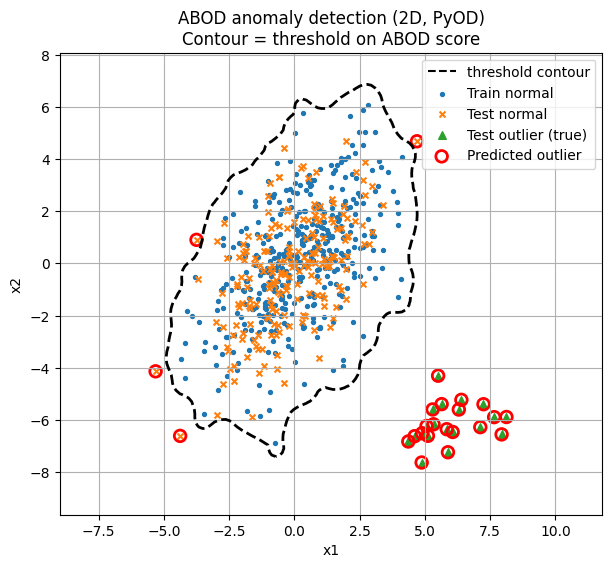

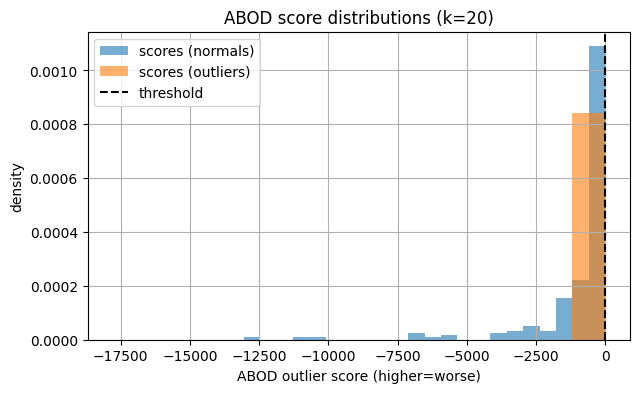

In [13]:
# ===== 可視化：散布図＋等高線 =====
def pairwise_l2(A, B):
    A2 = np.sum(A*A, axis=1, keepdims=True); B2 = np.sum(B*B, axis=1, keepdims=True).T
    D2 = A2 + B2 - 2*(A @ B.T); D2 = np.maximum(D2, 0.0)
    return np.sqrt(D2)

x_min, y_min = (np.min(np.vstack([train, test]), axis=0) - 2)
x_max, y_max = (np.max(np.vstack([train, test]), axis=0) + 2)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 120),
                     np.linspace(y_min, y_max, 120))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_z = (grid - mu_hat) / std_hat

# 大きなグリッドでも固まらないようにバッチ処理
def batched_decision(model, X, batch=5000):
    out = np.empty(X.shape[0], dtype=float)
    for i in range(0, X.shape[0], batch):
        out[i:i+batch] = model.decision_function(X[i:i+batch])
    return out

print("[INFO] Scoring grid ...")
score_grid = batched_decision(abod, grid_z, batch=4000).reshape(xx.shape)
print("[INFO] Grid scored.")

plt.figure(figsize=(7,6))
# 等高線：値域が不安定でも描けるように try/except でフォールバック
try:
    plt.contour(xx, yy, score_grid, levels=[thr], linestyles='--', linewidths=2, colors='k')
except Exception as e:
    # コンターが引けない場合は塗りつぶし等高線から等値線を代替
    cs = plt.contourf(xx, yy, score_grid, levels=20, alpha=0.3)
    plt.contour(xx, yy, score_grid, levels=[thr], linestyles='--', linewidths=2, colors='k')
# 凡例用のダミー線
plt.plot([], [], 'k--', label="threshold contour")

plt.scatter(train[:,0], train[:,1], s=8,  label="Train normal")
plt.scatter(test_norm[:,0], test_norm[:,1], s=18, marker='x', label="Test normal")
plt.scatter(test_out[:,0],  test_out[:,1],  s=30, marker='^', label="Test outlier (true)")
flag_idx = np.where(pred==1)[0]
plt.scatter(test[flag_idx,0], test[flag_idx,1], s=70, facecolors='none',
            edgecolors='red', linewidths=2, label="Predicted outlier")
plt.title("ABOD anomaly detection (2D, PyOD)\nContour = threshold on ABOD score")
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend(); plt.grid(True); plt.axis('equal')
plt.show()

# ===== スコアのヒスト（NaN/Inf除去 & クリップ）=====
s_norm = score_test[(labels==0) & np.isfinite(score_test)]
s_out  = score_test[(labels==1) & np.isfinite(score_test)]
if len(s_norm)==0 and len(s_out)==0:
    print("（可視化できる有効なスコアがありませんでした）")
else:
    lo = np.nanpercentile(score_test, 0.5)
    hi = np.nanpercentile(score_test, 99.5)
    plt.figure(figsize=(7,4))
    plt.hist(s_norm, bins=30, density=True, alpha=0.6, label="scores (normals)", range=(lo, hi))
    plt.hist(s_out,  bins=15, density=True, alpha=0.6, label="scores (outliers)", range=(lo, hi))
    plt.axvline(min(max(thr, lo), hi), linestyle='--', color='k', label="threshold")
    plt.title(f"ABOD score distributions (k={k})")
    plt.xlabel("ABOD outlier score (higher=worse)"); plt.ylabel("density")
    plt.legend(); plt.grid(True); plt.show()
